In [1]:
#1. Import modules
import os
import shutil
import glob
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import matplotlib.image as mpimg
import numpy as np

from obspy import read, read_inventory, read_events,Stream, UTCDateTime as UTC
from obspy.core.event import Catalog, Event, Origin, Magnitude
from obspy.geodetics import FlinnEngdahl
from obspy.geodetics import gps2dist_azimuth
from obspy.signal.trigger import classic_sta_lta, plot_trigger
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
import matplotlib.colors as colors
from rf import read_rf, RFStream
from rf import get_profile_boxes, iter_event_data, IterMultipleComponents
from rf.imaging import plot_profile_map
from rf.profile import profile
from tqdm import tqdm
from obspy.core import UTCDateTime
from obspy.io.sac import SACTrace # This is important for sac header editing
from obspy.taup import TauPyModel # For calculating arrival times
from obspy.core.util import NamedTemporaryFile
from obspy.clients.fdsn import Client as FDSN_Client
from obspy.clients.iris import Client as OldIris_Client

In [2]:
#2) Define node data directories and filenames
data_dir_name = 'kodiak_comp'
data_dir = os.path.join(data_dir_name, '')
pics_dir = os.path.join(data_dir + 'Figures', '')
EventParams_dir = os.path.join(data_dir + 'EventParams', '')
dropbox = '/home/evans/Dropbox/UNM/2ndPhD_project/' + data_dir_name
invfile = data_dir + 'station3001.xml'
invfile2 = data_dir + 'stationKD02.xml'
invfile3 = './data/edited_stations.xml'
inventory3 = read_inventory(invfile3)
catfile = './data/events.xml'
datafile1 = data_dir + 'nodal_3001_kodiak_data.h5'
datafile2 = data_dir + 'bb_KD02_kodiak_data.h5'


# Define Station Window parameters
network1 = '8J'
network2 = 'XO'
station1 = '3001'
station2 = 'KD02'
channel1 = 'DP?'
channel2 = 'HH?'
starttime = '2019-05-16'
endtime = '2019-06-23'
centroid = [57.645508, -152.519952] # Array centroid station coordinates

# Define Event window parameters
baz_window = [0, 360] #  Min and max Back azimuth window
epicentral_window = [30, 90] # Min and max epicentral distance (degrees)
mag_window = [5.0, 10.0] # Min and max magnitude window

# Processing and plotting parameters
timeStart = 10
timeLength = 75
minFreq = 0.1
maxFreq = 2.0

# Create directories if they don't exist already
if not os.path.exists(data_dir):  # create data directory if necessary
    os.mkdir(data_dir)
    
if not os.path.exists(pics_dir):  # create pics directory if necessary
    os.mkdir(pics_dir)
    
if not os.path.exists(EventParams_dir):  # create event parameters directory if necessary
    os.mkdir(EventParams_dir)
    
if not os.path.exists(dropbox):  # create dropbox backup directory if necessary
    os.mkdir(dropbox)

In [3]:
# Initiate catalog
catalog = Catalog()

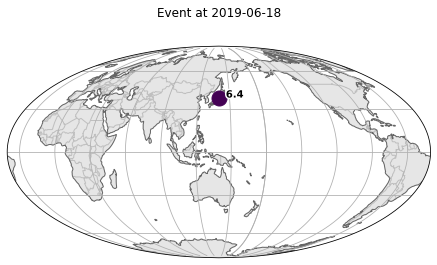

In [4]:
#1
time = "2019-06-18T13:22:19.009000Z"
lat = +38.637
lon = +139.480
mag = 6.4

client = FDSN_Client()
cat = client.get_events(starttime=time, endtime=time, minlatitude=lat, minlongitude=lon, 
                            minmagnitude=mag)
cat.plot(method='cartopy');
catalog.append(cat[0])

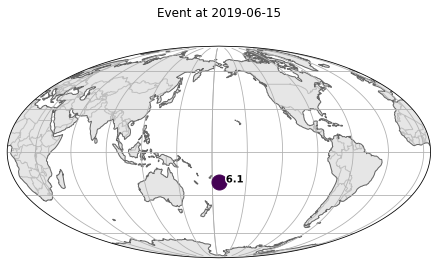

In [5]:
#2
time = "2019-06-15T21:56:10.835000Z"
lat = -21.181
lon = -174.169
mag = 6.1
client = FDSN_Client()
cat = client.get_events(starttime=time, endtime=time, minlatitude=lat, minlongitude=lon, 
                            minmagnitude=mag)
cat.plot(method='cartopy');
catalog.append(cat[0])

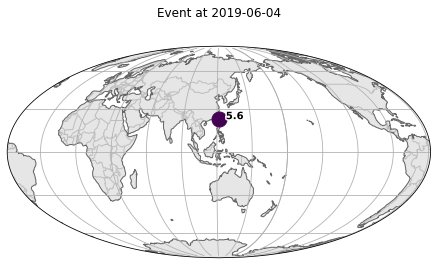

In [6]:
#3
time = "2019-06-04T09:46:18.443000Z"
lat = +22.881
lon = +121.670
mag = 5.6
client = FDSN_Client()
cat = client.get_events(starttime=time, endtime=time, minlatitude=lat, minlongitude=lon, 
                            minmagnitude=mag)
cat.plot(method='cartopy');
catalog.append(cat[0])

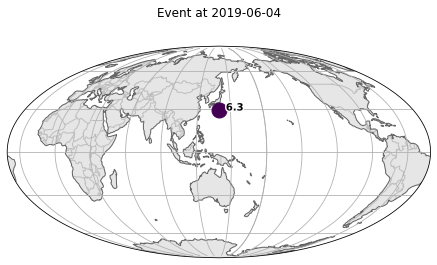

In [7]:
#4
#2019-06-04T04:39:17.501000Z | +29.062, +139.293 | 6.3 Mww
time = "2019-06-04T04:39:17.501000Z"
lat = +29.062
lon = +139.293
mag = 6.3
client = FDSN_Client()
cat = client.get_events(starttime=time, endtime=time, minlatitude=lat, minlongitude=lon, 
                            minmagnitude=mag)
cat.plot(method='cartopy');
catalog.append(cat[0])

1 Event(s) in Catalog:
2019-06-02T10:36:29.659000Z | -21.209, -173.908 | 6.0 Mww


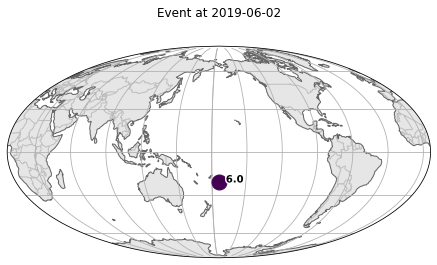

In [8]:
#5
mag = 6.0
coords = [57.645508, -152.519952]
client = FDSN_Client()
kwargs = {'starttime': UTC('2019-06-02'), 'endtime': UTC('2019-06-03'),
          'latitude': coords[0], 'longitude': coords[1],
          'minradius': 30, 'maxradius': 90,
          'minmagnitude': mag, 'maxmagnitude': mag}
cat = client.get_events(**kwargs)

print(cat)
cat.plot(method='cartopy');
catalog.append(cat[0])

1 Event(s) in Catalog:
2019-05-26T07:41:15.058000Z |  -5.813,  -75.278 | 8.0 Mww


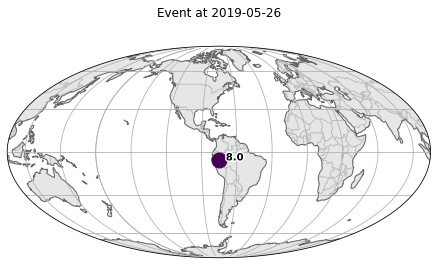

In [9]:
#6
mag = 8.0
coords = [57.645508, -152.519952]
client = FDSN_Client()
kwargs = {'starttime': UTC('2019-05-26'), 'endtime': UTC('2019-05-27'),
          'latitude': coords[0], 'longitude': coords[1],
          'minradius': 30, 'maxradius': 90,
          'minmagnitude': mag, 'maxmagnitude': mag}
cat = client.get_events(**kwargs)

print(cat)
cat.plot(method='cartopy');
catalog.append(cat[0])

1 Event(s) in Catalog:
2019-05-30T09:03:28.971000Z | +13.146,  -89.366 | 6.6 Mww


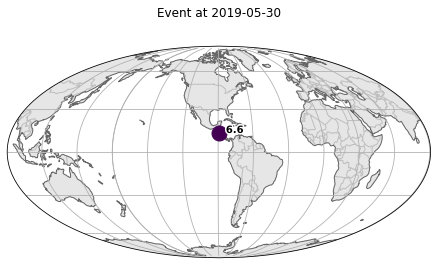

In [10]:
#7
mag = 6.6
coords = [57.645508, -152.519952]
client = FDSN_Client()
kwargs = {'starttime': UTC('2019-05-30'), 'endtime': UTC('2019-05-31'),
          'latitude': coords[0], 'longitude': coords[1],
          'minradius': 30, 'maxradius': 90,
          'minmagnitude': mag, 'maxmagnitude': mag}
cat = client.get_events(**kwargs)

print(cat)
cat.plot(method='cartopy');
catalog.append(cat[0])

7 Event(s) in Catalog:
2019-06-18T13:22:19.009000Z | +38.637, +139.480 | 6.4 Mww
2019-06-15T21:56:10.835000Z | -21.181, -174.169 | 6.1 Mww
2019-06-04T09:46:18.443000Z | +22.881, +121.670 | 5.6 Mww
2019-06-04T04:39:17.501000Z | +29.062, +139.293 | 6.3 Mww
2019-06-02T10:36:29.659000Z | -21.209, -173.908 | 6.0 Mww
2019-05-26T07:41:15.058000Z |  -5.813,  -75.278 | 8.0 Mww
2019-05-30T09:03:28.971000Z | +13.146,  -89.366 | 6.6 Mww


/home/evans/anaconda3/envs/seispy/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


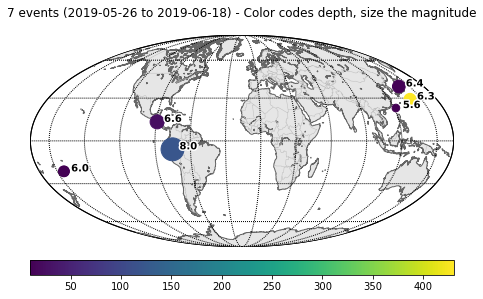

In [11]:
# Write catalog and plot map
catalog.write(catfile, 'QUAKEML')
print(catalog)
catalog.plot();

Installed new opener with handlers: [<obspy.clients.fdsn.client.CustomRedirectHandler object at 0x7f93fbde2390>]
Base URL: http://service.iris.edu
Custom service mappings:
	station: 'http://service.iris.edu/ph5ws/station/1'
Request Headers: {'User-Agent': 'ObsPy/1.2.2 (Linux-4.15.0-175-generic-x86_64-with-debian-buster-sid, Python 3.7.10)'}

Uncompressing gzipped response for http://service.iris.edu/fdsnws/dataselect/1/application.wadl
Downloaded http://service.iris.edu/fdsnws/dataselect/1/application.wadl with HTTP code: 200
Downloaded http://service.iris.edu/fdsnws/event/1/catalogs with HTTP code: 200
Uncompressing gzipped response for http://service.iris.edu/fdsnws/event/1/contributors
Downloaded http://service.iris.edu/fdsnws/event/1/contributors with HTTP code: 200
Uncompressing gzipped response for http://service.iris.edu/ph5ws/station/1/application.wadl
Downloaded http://service.iris.edu/ph5ws/station/1/application.wadl with HTTP code: 200
Uncompressing gzipped response for http

/home/evans/anaconda3/envs/seispy/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


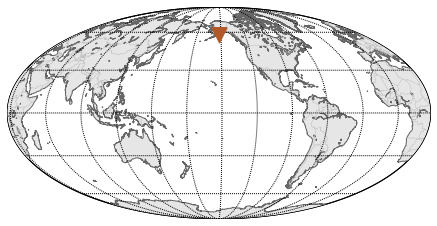

/home/evans/anaconda3/envs/seispy/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


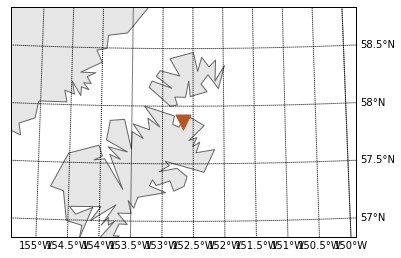

In [12]:
##) Fetch Stations via PH5 Station Web Service
#Specify level='response' to get all information including instrument response for each channel

STATION = 'http://service.iris.edu/ph5ws/station/1'

if not os.path.exists(invfile):
    client = FDSN_Client('http://service.iris.edu',
                    service_mappings={
                        'station': STATION
                    },
                    debug=True
                   )
    inventory = client.get_stations(network=network1, station=station1,
                                    location='*', channel=channel1, level='response',
                                    starttime=UTC(starttime),
                                    endtime=UTC(endtime))
    inventory.write(invfile, 'STATIONXML')
inventory = read_inventory(invfile)
inventory.plot(label=False);
inventory.plot('local', color_per_network=False, label=False, outfile=pics_dir + 'stations_local.png');

Inventory created at 2022-04-07T01:41:57.250000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2019-05-16...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			XO
		Stations (1):
			XO.KD02 (Anton Larsen Bay, AK)
		Channels (3):
			XO.KD02..HHZ, XO.KD02..HHN, XO.KD02..HHE


/home/evans/anaconda3/envs/seispy/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


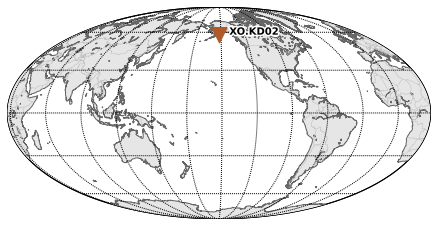

In [13]:
# Fetch Broadband Stations
client2 = FDSN_Client("IRIS")

inventory2 = client2.get_stations(network=network2, station=station2, channel=channel2, 
                                level='response', location='*', starttime=UTC(starttime), endtime=UTC(endtime))

inventory2.write(invfile2, 'STATIONXML')
print(inventory2)
inventory2.plot();

In [14]:
#5) Fetch waveforms via PH5 Dataselect Web Service Request (Requests -20 s to 90 s by default)
DATASELECT = 'http://service.iris.edu/ph5ws/dataselect/1'

if not os.path.exists(datafile1):
    client = FDSN_Client('http://service.iris.edu',
                    service_mappings={
                        'dataselect': DATASELECT
                    }, debug=True
                   )
    stream = Stream()
    with tqdm() as pbar:
        for s in iter_event_data(catalog, inventory, client.get_waveforms, phase='P',
                                 request_window=(-20, 90), pbar=pbar):
            stream.extend(s)
    stream.write(datafile1, 'H5')

Installed new opener with handlers: [<obspy.clients.fdsn.client.CustomRedirectHandler object at 0x7f93fbe57410>]
Base URL: http://service.iris.edu
Custom service mappings:
	dataselect: 'http://service.iris.edu/ph5ws/dataselect/1'
Request Headers: {'User-Agent': 'ObsPy/1.2.2 (Linux-4.15.0-175-generic-x86_64-with-debian-buster-sid, Python 3.7.10)'}
Downloaded http://service.iris.edu/fdsnws/event/1/catalogs with HTTP code: 200
Uncompressing gzipped response for http://service.iris.edu/fdsnws/event/1/contributors
Downloaded http://service.iris.edu/fdsnws/event/1/contributors with HTTP code: 200
Uncompressing gzipped response for http://service.iris.edu/ph5ws/dataselect/1/application.wadl
Downloaded http://service.iris.edu/ph5ws/dataselect/1/application.wadl with HTTP code: 200


0it [00:00, ?it/s]

Uncompressing gzipped response for http://service.iris.edu/fdsnws/station/1/application.wadl
Downloaded http://service.iris.edu/fdsnws/station/1/application.wadl with HTTP code: 200
Uncompressing gzipped response for http://service.iris.edu/fdsnws/event/1/application.wadl
Downloaded http://service.iris.edu/fdsnws/event/1/application.wadl with HTTP code: 200
Discovered dataselect service
Discovered station service
Discovered event service
Storing discovered services in cache.


 29%|██▊       | 2/7 [00:09<00:24,  4.99s/it]

Downloaded http://service.iris.edu/ph5ws/dataselect/1/query?starttime=2019-06-18T13%3A30%3A18.721768&endtime=2019-06-18T13%3A32%3A28.721768&network=8J&station=3001&location=--&channel=DP%3F with HTTP code: 200


 43%|████▎     | 3/7 [00:15<00:21,  5.25s/it]

Downloaded http://service.iris.edu/ph5ws/dataselect/1/query?starttime=2019-06-15T22%3A07%3A54.141122&endtime=2019-06-15T22%3A10%3A04.141122&network=8J&station=3001&location=--&channel=DP%3F with HTTP code: 200


 57%|█████▋    | 4/7 [00:20<00:15,  5.30s/it]

Downloaded http://service.iris.edu/ph5ws/dataselect/1/query?starttime=2019-06-04T09%3A56%3A51.626996&endtime=2019-06-04T09%3A59%3A01.626996&network=8J&station=3001&location=--&channel=DP%3F with HTTP code: 200


 71%|███████▏  | 5/7 [00:26<00:10,  5.37s/it]

Downloaded http://service.iris.edu/ph5ws/dataselect/1/query?starttime=2019-06-04T04%3A47%3A31.410719&endtime=2019-06-04T04%3A49%3A41.410719&network=8J&station=3001&location=--&channel=DP%3F with HTTP code: 200


 86%|████████▌ | 6/7 [00:32<00:05,  5.49s/it]

Downloaded http://service.iris.edu/ph5ws/dataselect/1/query?starttime=2019-06-02T10%3A48%3A13.352604&endtime=2019-06-02T10%3A50%3A23.352604&network=8J&station=3001&location=--&channel=DP%3F with HTTP code: 200


100%|██████████| 7/7 [00:37<00:00,  5.48s/it]

Downloaded http://service.iris.edu/ph5ws/dataselect/1/query?starttime=2019-05-26T07%3A53%3A22.305253&endtime=2019-05-26T07%3A55%3A32.305253&network=8J&station=3001&location=--&channel=DP%3F with HTTP code: 200


100%|██████████| 7/7 [00:42<00:00,  6.09s/it]

Downloaded http://service.iris.edu/ph5ws/dataselect/1/query?starttime=2019-05-30T09%3A13%3A35.673451&endtime=2019-05-30T09%3A15%3A45.673451&network=8J&station=3001&location=--&channel=DP%3F with HTTP code: 200


In [15]:
print(stream)

21 Trace(s) in Stream:

8J.3001..DP1 | -20.0s - 90.0s onset:2019-06-18T13:30:48.721768Z | 500.0 Hz, 55001 samples | mag:6.4 dist:46.9 baz:276.6 slow:7.83
...
(19 other traces)
...
8J.3001..DPZ | -20.0s - 90.0s onset:2019-05-30T09:14:05.673451Z | 500.0 Hz, 55001 samples | mag:6.6 dist:64.8 baz:105.9 slow:6.52

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [16]:
print(stream.__str__(extended=True))

21 Trace(s) in Stream:
8J.3001..DP1 | -20.0s - 90.0s onset:2019-06-18T13:30:48.721768Z | 500.0 Hz, 55001 samples | mag:6.4 dist:46.9 baz:276.6 slow:7.83
8J.3001..DP2 | -20.0s - 90.0s onset:2019-06-18T13:30:48.721768Z | 500.0 Hz, 55001 samples | mag:6.4 dist:46.9 baz:276.6 slow:7.83
8J.3001..DPZ | -20.0s - 90.0s onset:2019-06-18T13:30:48.721768Z | 500.0 Hz, 55001 samples | mag:6.4 dist:46.9 baz:276.6 slow:7.83
8J.3001..DP1 | -20.0s - 90.0s onset:2019-06-15T22:08:24.141122Z | 500.0 Hz, 55001 samples | mag:6.1 dist:80.8 baz:200.3 slow:5.34
8J.3001..DP2 | -20.0s - 90.0s onset:2019-06-15T22:08:24.141122Z | 500.0 Hz, 55001 samples | mag:6.1 dist:80.8 baz:200.3 slow:5.34
8J.3001..DPZ | -20.0s - 90.0s onset:2019-06-15T22:08:24.141122Z | 500.0 Hz, 55001 samples | mag:6.1 dist:80.8 baz:200.3 slow:5.34
8J.3001..DP1 | -20.0s - 90.0s onset:2019-06-04T09:57:21.626996Z | 500.0 Hz, 55001 samples | mag:5.6 dist:68.6 baz:279.2 slow:6.25
8J.3001..DP2 | -20.0s - 90.0s onset:2019-06-04T09:57:21.626996Z | 5

In [17]:
# Fetch waveforms
client2 = FDSN_Client("IRIS")

if not os.path.exists(datafile2):
    stream2 = Stream()
    with tqdm() as pbar:
        for s in iter_event_data(catalog, inventory2, client2.get_waveforms, phase='P',
                                 request_window=(-20, 90), pbar=pbar):
            stream2.extend(s)
    stream2.write(datafile2, 'H5')

100%|██████████| 7/7 [00:06<00:00,  1.11it/s]


In [18]:
print(stream2)

21 Trace(s) in Stream:

XO.KD02..HHE | -20.0s - 90.0s onset:2019-06-18T13:30:48.722183Z | 100.0 Hz, 11001 samples | mag:6.4 dist:46.9 baz:276.6 slow:7.83
...
(19 other traces)
...
XO.KD02..HHZ | -20.0s - 90.0s onset:2019-05-30T09:14:05.673116Z | 100.0 Hz, 11001 samples | mag:6.6 dist:64.8 baz:105.9 slow:6.52

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [19]:
# Isolate the Honshu event
stream_3001 = Stream()
stream_KD02 = Stream()
for tr in stream:
    if tr.stats.event_magnitude == 6.3:
        stream_3001 += tr
        
for tr in stream2:
    if tr.stats.event_magnitude == 6.3:
        stream_KD02 += tr        

In [20]:
print(stream_3001.select(channel='DPZ'))
print("")
print(stream_KD02.select(channel='HHZ'))

1 Trace(s) in Stream:
8J.3001..DPZ | -20.0s - 90.0s onset:2019-06-04T04:48:01.410719Z | 500.0 Hz, 55001 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10

1 Trace(s) in Stream:
XO.KD02..HHZ | -20.0s - 90.0s onset:2019-06-04T04:48:01.411098Z | 100.0 Hz, 11001 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10


XO.KD02..HHZ | -20.0s - 90.0s onset:2019-06-04T04:48:01.411098Z | 100.0 Hz, 11001 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10

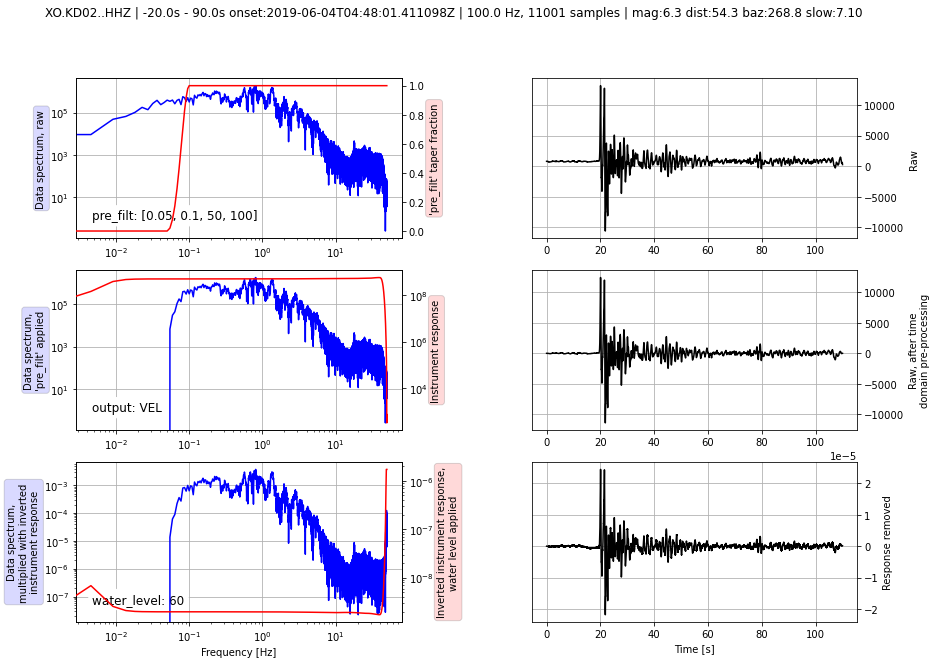

In [21]:
## Instrument response removal Testing
# Copy a trace
tr = stream_KD02.select(channel='HHZ')[0].copy()
# Set pre_filter and water_level params, then remove response
pre_filt = [0.05, 0.1, tr.stats.sampling_rate/2, tr.stats.sampling_rate]
water_level = 60
tr.remove_response(inventory=inventory2, pre_filt=pre_filt, output="VEL",
                  water_level=water_level, plot=True)

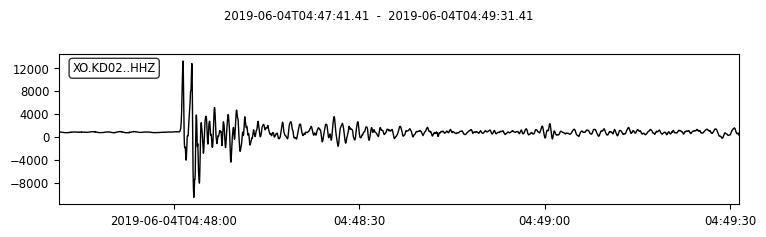

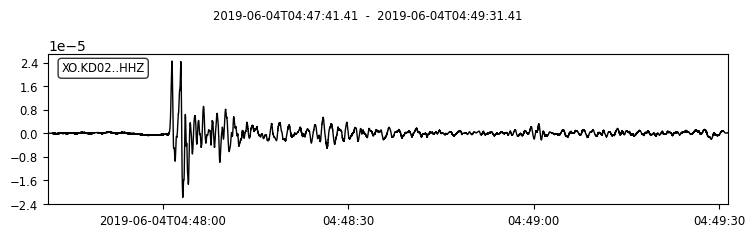

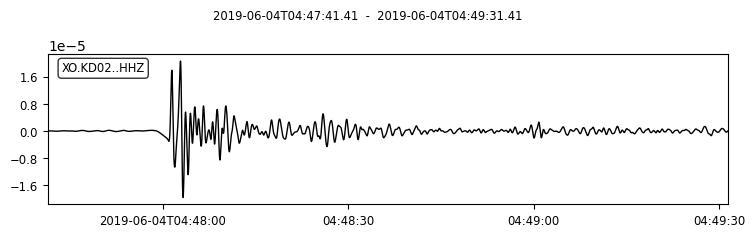

In [22]:
# Plot results
stream_KD02.select(channel='HHZ').plot();
tr.plot();
#tr.filter('bandpass', freqmin=0.05, freqmax=0.5, corners=2, zerophase=True)
tr.filter('bandpass', freqmin=0.2, freqmax=2.0, corners=2, zerophase=True)
tr.plot();

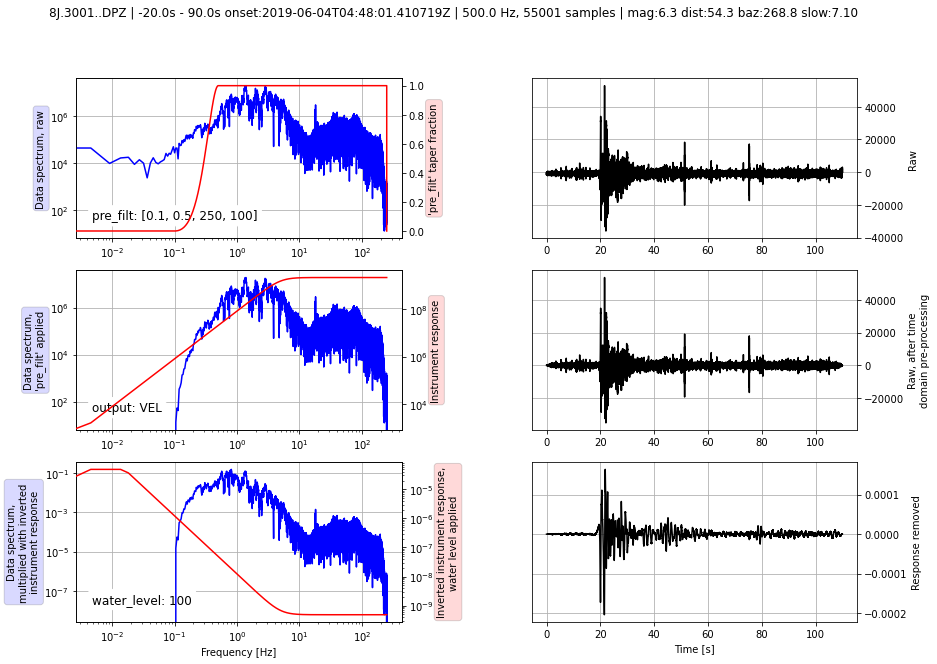

In [23]:
## Instrument response removal Testing
# Copy a trace
trr = stream_3001.select(channel='DPZ')[0].copy()
# Set pre_filter and water_level params, then remove response
pre_filt = [0.1, 0.5, trr.stats.sampling_rate/2, tr.stats.sampling_rate]
water_level = 100
trr.remove_response(inventory=inventory3, pre_filt=pre_filt, output="VEL",
                  water_level=water_level, plot=True)
trr.data = trr.data * -1

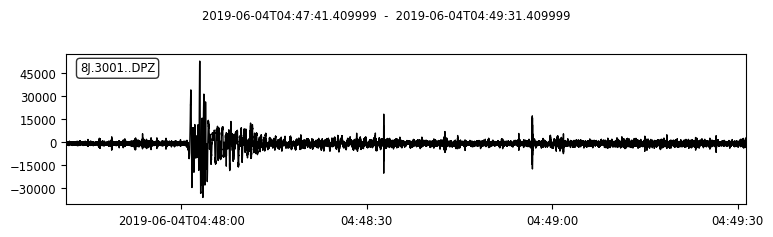

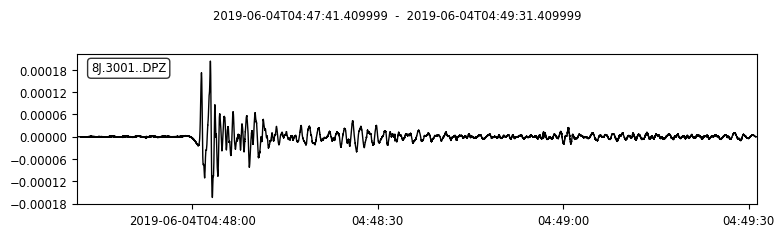

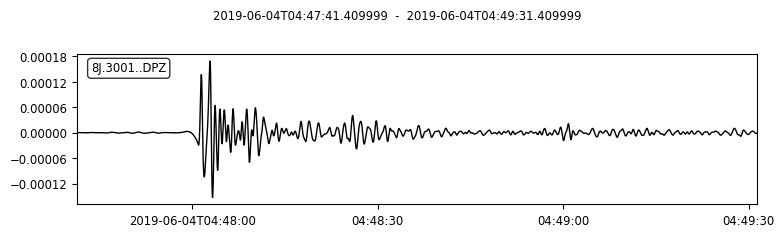

In [24]:
# Plot results
stream_3001.select(channel='DPZ').plot();
trr.plot();
#tr.filter('bandpass', freqmin=0.05, freqmax=0.5, corners=2, zerophase=True)
trr.filter('bandpass', freqmin=0.2, freqmax=2.0, corners=2, zerophase=True)
trr.plot();

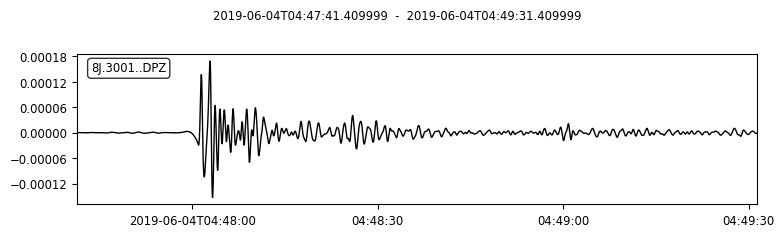

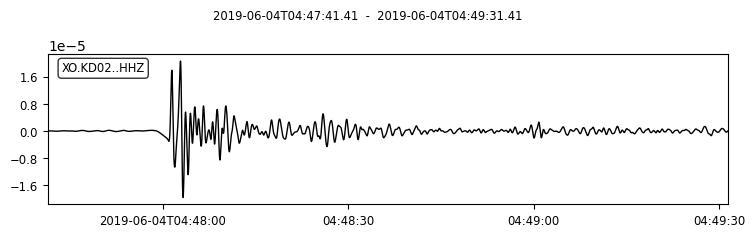

In [25]:
# Compare broadband and Nodal response removed
trr.plot();
tr.plot();

In [26]:
### Remove instrument response from all 3 components of broadband station KD02

## Set pre_filter and water_level params, then remove response
#pre_filt = [0.05, 0.1, stream_KD02[0].stats.sampling_rate/2, stream_KD02[0].stats.sampling_rate]
#water_level = 60
#stream_KD02.remove_response(inventory=inventory2, pre_filt=pre_filt, output="VEL",
#                  water_level=water_level, plot=False)

In [27]:
##) Remove instrument response from broadband data and scale it

pre_filt = [0.05, 0.1, stream_KD02[0].stats.sampling_rate/2, stream_KD02[0].stats.sampling_rate]
water_level = 60

for tr1 in stream_KD02:
    network = tr1.stats.network
    station = tr1.stats.station
    channel = tr1.stats.channel
    tr1.remove_response(inventory=inventory2, pre_filt=pre_filt, output="VEL",
                       water_level=water_level, plot=False)
    
    # Scale Broadband instrument data
    tr1.data = tr1.data * 7.5

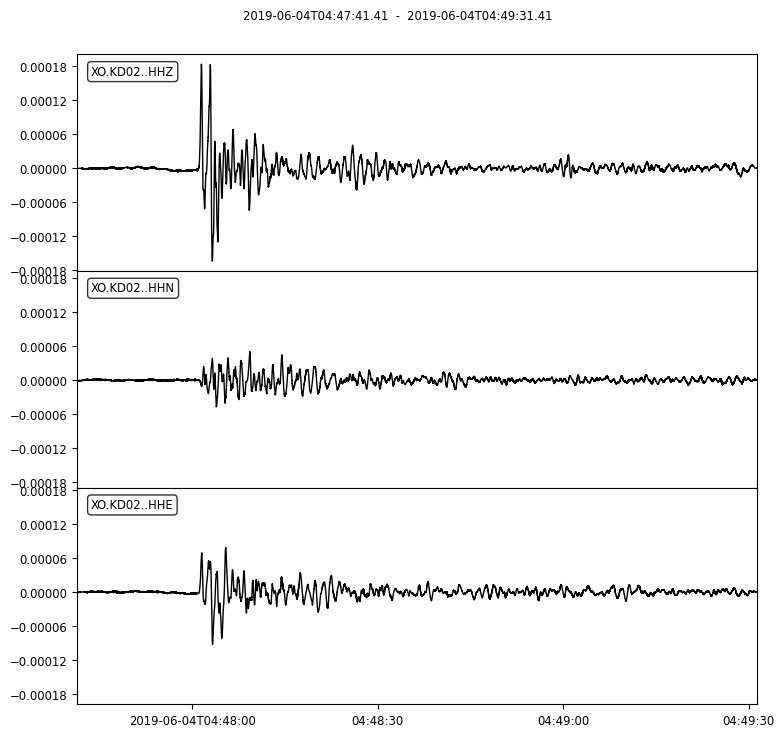

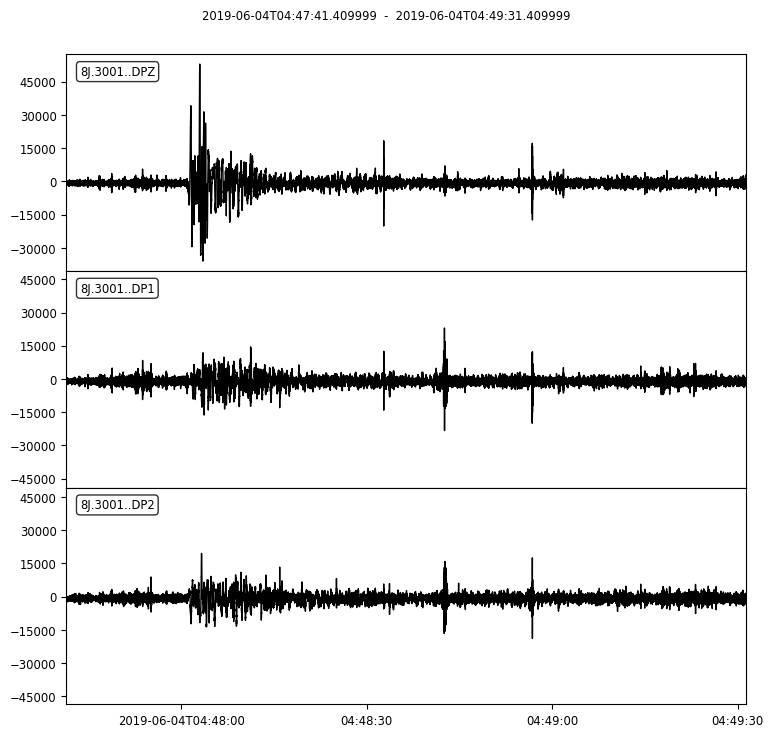

In [28]:
stream_KD02.plot();
stream_3001.plot();

In [29]:
### Remove instrument response from all 3 components of nodal station 3001

## Set pre_filter and water_level params, then remove response
#pre_filt = [0.1, 0.5, stream_3001[0].stats.sampling_rate/2, stream_3001[0].stats.sampling_rate]
#water_level = 100
#stream_3001.remove_response(inventory=inventory3, pre_filt=pre_filt, output="VEL",
#                  water_level=water_level, plot=False)

In [30]:
##) Remove instrument response from node data and flip DPZ polarity
# read nodal waveform and station data
#stream = read_rf(datafile, 'H5')

pre_filt = [0.1, 0.5, stream_3001[0].stats.sampling_rate/2, stream_3001[0].stats.sampling_rate]
water_level = 100
for tr1 in stream_3001:
    network = tr1.stats.network
    station = tr1.stats.station
    channel = tr1.stats.channel
    tr1.remove_response(inventory=inventory3, pre_filt=pre_filt, output="VEL",
                       water_level=water_level, plot=False)
    # Integrate the waveforms to convert from acceleration to velocity
    #tr1.integrate(method='cumtrapz')
    # Correct polarity for DPZ
    if (channel == "DPZ"):
        tr1.data = tr1.data * -1

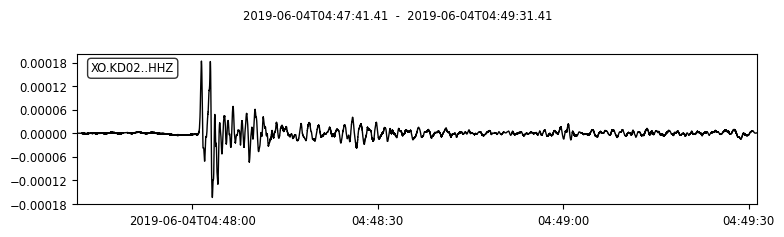

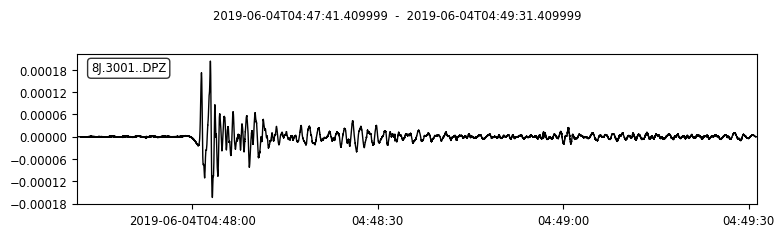

In [31]:
stream_KD02.select(channel='*Z').plot();
stream_3001.select(channel='*Z').plot(); # Need to flip polarity on Z.

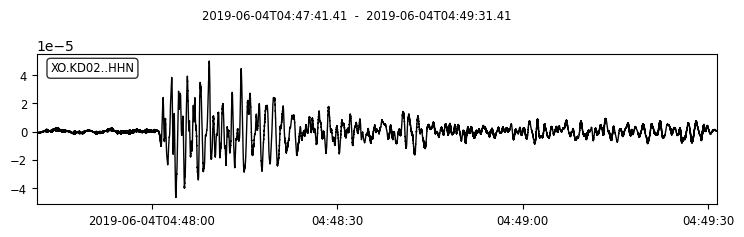

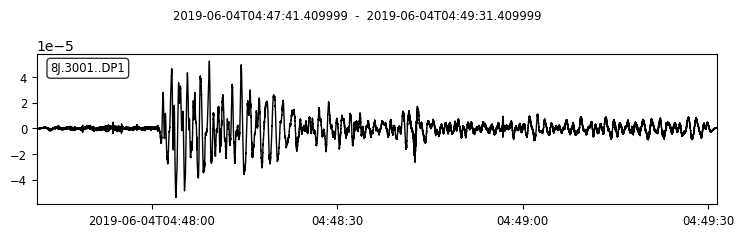

In [32]:
stream_KD02.select(channel='*N').plot();
stream_3001.select(channel='*1').plot();

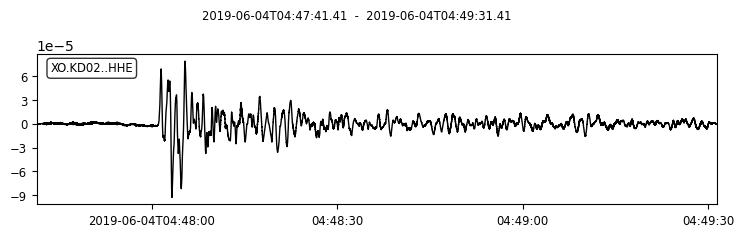

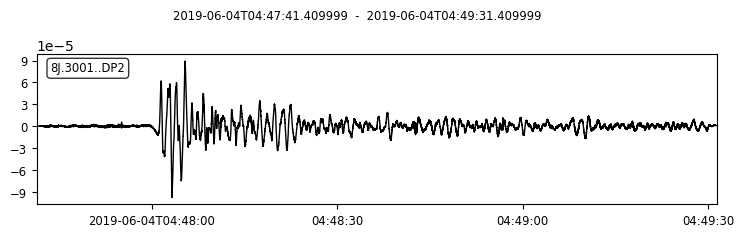

In [33]:
stream_KD02.select(channel='*E').plot();
stream_3001.select(channel='*2').plot();

In [34]:
## Copy the instrument response removed streams
stream_KD02c = stream_KD02.copy()
stream_3001c = stream_3001.copy()

## Resample the copied datasets to 50 Hz
nu_sr = 50
stream_KD02c.filter('lowpass', freq=0.5*nu_sr, corners=2, zerophase=True)
stream_KD02c.resample(nu_sr, no_filter=True)

stream_3001c.filter('lowpass', freq=0.5*nu_sr, corners=2, zerophase=True)
stream_3001c.resample(nu_sr, no_filter=True)

3 Trace(s) in Stream:
8J.3001..DP1 | -20.0s - 90.0s onset:2019-06-04T04:48:01.410719Z | 50.0 Hz, 5500 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10
8J.3001..DP2 | -20.0s - 90.0s onset:2019-06-04T04:48:01.410719Z | 50.0 Hz, 5500 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10
8J.3001..DPZ | -20.0s - 90.0s onset:2019-06-04T04:48:01.410719Z | 50.0 Hz, 5500 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10

In [35]:
## Demean, detrend and taper the data
stream_KD02c.detrend('demean').detrend('linear').taper(max_percentage=0.05, max_length=5.)
stream_3001c.detrend('demean').detrend('linear').taper(max_percentage=0.05, max_length=5.)

## Bandpass filter the datasets
stream_KD02c.filter('bandpass', freqmin=0.2, freqmax=2)
stream_3001c.filter('bandpass', freqmin=0.2, freqmax=2)

3 Trace(s) in Stream:
8J.3001..DP1 | -20.0s - 90.0s onset:2019-06-04T04:48:01.410719Z | 50.0 Hz, 5500 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10
8J.3001..DP2 | -20.0s - 90.0s onset:2019-06-04T04:48:01.410719Z | 50.0 Hz, 5500 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10
8J.3001..DPZ | -20.0s - 90.0s onset:2019-06-04T04:48:01.410719Z | 50.0 Hz, 5500 samples | mag:6.3 dist:54.3 baz:268.8 slow:7.10

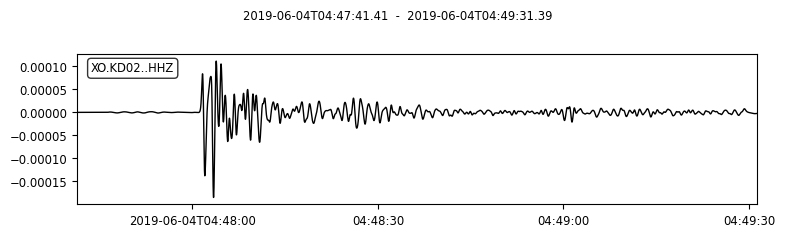

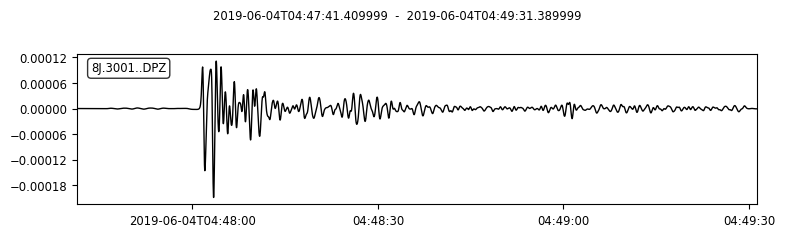

In [36]:
stream_KD02c.select(channel='*Z').plot();
stream_3001c.select(channel='*Z').plot(); # Need to flip polarity on Z.

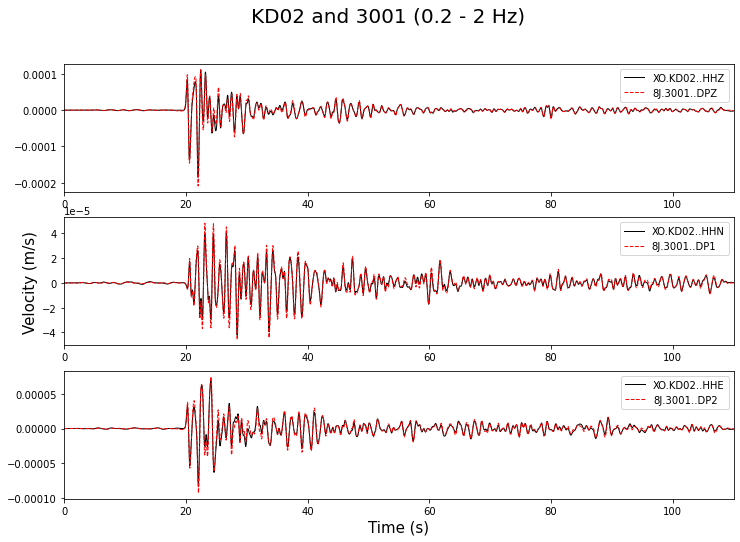

In [37]:
##) Plot KD02 and 3001 waveform comparison
tr_z = stream_KD02c.select(channel='*Z')[0].copy()
tr_n = stream_KD02c.select(channel='*N')[0].copy()
tr_e = stream_KD02c.select(channel='*E')[0].copy()
tr_zn = stream_3001c.select(channel='*Z')[0].copy()
tr_nn = stream_3001c.select(channel='*1')[0].copy()
tr_en = stream_3001c.select(channel='*2')[0].copy()
time = tr_zn.times()

#tr_z.data = tr_z.data * 7.5
#tr_n.data = tr_n.data * 7.5
#tr_e.data = tr_e.data * 7.5
#tr_zn.data = tr_zn.data * -1

pic = pics_dir + 'waveformComparison' + '.png'

#subplot(nrows, ncols, index, **kwargs)
fig, axs = plt.subplots(figsize=(12,8)) 
plt.axis('off')
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)         
ax.plot(time,tr_z,'k', linewidth=1.0, label = tr_z.id, zorder=1) #background
ax.plot(time,tr_zn, 'r--', linewidth=1.0, label = tr_zn.id, zorder=2) #foreground
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend()

ax2.plot(time,tr_n,'k', linewidth=1.0, label = tr_n.id, zorder=1)
ax2.plot(time,tr_nn, 'r--', linewidth=1.0, label = tr_nn.id, zorder=2)
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.legend()

ax3.plot(time,tr_e,'k', linewidth=1.0, label = tr_e.id, zorder=1)
ax3.plot(time,tr_en, 'r--', linewidth=1.0, label = tr_en.id, zorder=2)
ax3.autoscale(enable=True, axis='x', tight=True)
ax3.legend()

# title and labels, setting initial sizes
fig.suptitle('KD02 and 3001 (0.2 - 2 Hz)', fontsize=20)
ax3.set_xlabel('Time (s)', fontsize=15)
ax2.set_ylabel('Velocity (m/s)', fontsize=15)

## Save figure
fig.savefig(pic)